# Data generation

### Generate the data

In [1]:
import numpy as np

num_classes = 10
num_per_class = 2000
cov_scale = 1.2
means = [[i, i] for i in range(num_classes)]
covs = [np.random.rand(2,2)*cov_scale for i in range(num_classes)]

labels = np.array([item for sublist in [[i]* num_per_class for i in range(num_classes)] for item in sublist]) 

x = np.array([np.random.multivariate_normal(means[i], covs[i], num_per_class) for i in range(num_classes)])
x = x.reshape((num_classes * num_per_class, 2))

<ipython-input-1-206b5bbb2e4d>:11: RuntimeWarning: covariance is not positive-semidefinite.
  x = np.array([np.random.multivariate_normal(means[i], covs[i], num_per_class) for i in range(num_classes)])


### Plot the data

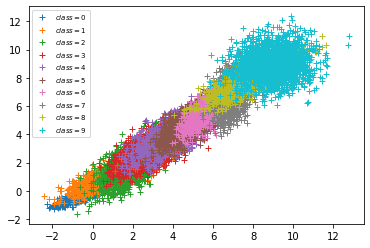

In [2]:
import matplotlib.pyplot as plt

for i in range(num_classes):
    plt.plot(x[i*num_per_class: (i+1)*num_per_class, 0], 
             x[i*num_per_class: (i+1)*num_per_class, 1], 
             '+',
             label='$class ={i}$'.format(i=i), 
            )
plt.legend(loc='best', prop={'size': 7})
plt.show()

### Split the data

In [3]:
import random
shuffled_indices = [i for i in range(num_classes * num_per_class)]
random.shuffle(shuffled_indices)
x = x[shuffled_indices, :]
#print(x.shape)
labels = labels[shuffled_indices]

train_ratio = 0.2
train_num = int(train_ratio * num_classes * num_per_class)

x_tr = x[:train_num, :]
y_tr = labels[:train_num]
x_rest = x[train_num:, :]
y_rest = labels[train_num:]

### Create datasets

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
class Data(Dataset):
    def __init__(self, x_train, y_train):
        self.x=torch.from_numpy(x_train)
        self.y=torch.from_numpy(y_train)
        self.len=self.x.shape[0]
        
    def __getitem__(self,index):      
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.len
    
train_dataset = Data(x_tr, y_tr)
rest_dataset = Data(x_rest, y_rest)

# Model

### Build the model 

In [5]:
import torch.nn as nn
class MultiClassModel(nn.Module):
    def __init__(self,D_in,H,D_out):
        super(MultiClassModel,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.linear2=nn.Linear(H,D_out)

        
    def forward(self,x):
        x=torch.sigmoid(self.linear1(x.float()))  
        x=self.linear2(x)  
        return x
    
hidden_dim = 50
model=MultiClassModel(2, hidden_dim, num_classes)

In [6]:
print(model)

MultiClassModel(
  (linear1): Linear(in_features=2, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=10, bias=True)
)


In [7]:
from torchsummary import summary
summary(model, (64,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 64, 50]             150
            Linear-2               [-1, 64, 10]             510
Total params: 660
Trainable params: 660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


### Train the model 

In [ ]:
criterion=nn.CrossEntropyLoss()
learning_rate=0.05
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
n_epochs=3000
loss_list=[]
trainloader=DataLoader(dataset=train_dataset,batch_size=64)

for epoch in range(n_epochs):
    for x, y in trainloader:       
        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        z=model(x)
        # calculate loss
        loss=criterion(z,y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
        
        loss_list.append(loss.data)
    if epoch%100 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 2.133866548538208
epoch 100, loss 1.134729027748108
epoch 200, loss 1.0741662979125977
epoch 300, loss 1.066692590713501
epoch 400, loss 1.066475510597229
epoch 500, loss 1.0676424503326416
epoch 600, loss 1.0694591999053955
epoch 700, loss 1.0708253383636475
epoch 800, loss 1.0712674856185913
epoch 900, loss 1.0710184574127197
epoch 1000, loss 1.0703997611999512
epoch 1100, loss 1.0695587396621704
epoch 1200, loss 1.0685086250305176
epoch 1300, loss 1.0672335624694824
epoch 1400, loss 1.0657442808151245
epoch 1500, loss 1.0640830993652344
epoch 1600, loss 1.0623024702072144
epoch 1700, loss 1.0604556798934937
epoch 1800, loss 1.058591365814209
epoch 1900, loss 1.0567606687545776
epoch 2000, loss 1.0550169944763184
epoch 2100, loss 1.0534003973007202
epoch 2200, loss 1.0519304275512695
epoch 2300, loss 1.050608515739441
epoch 2400, loss 1.0494260787963867
epoch 2500, loss 1.0483704805374146
epoch 2600, loss 1.0474278926849365


### Run inference

In [ ]:
z=model(torch.from_numpy(x_rest))
yhat=torch.max(z.data,1)
yhat

### Write the simulation data to csv

In [ ]:
import pandas as pd

predicted_label = np.argmax(z.data, axis =1).numpy()

outputs = np.concatenate((np.arange(len(y_rest)).reshape(len(y_rest), 1), 
                          y_rest.astype(int).reshape(len(y_rest), 1), 
                          predicted_label.astype(int).reshape(len(predicted_label), 1), 
                          z.data), axis =1)
df = pd.DataFrame(outputs)
df.to_csv("output.csv")

### Get accuracy 

In [ ]:
restdata_loader=DataLoader(dataset=rest_dataset,batch_size=64)
correct = 0
total = 0
for x, y in restdata_loader:
    z0 = model(x)
    pred = z0.max(1, keepdim=True)[1] # get the index of the max logit
    correct += pred.eq(y.view_as(pred)).sum().item()
    total += int(y.shape[0])
correct / total